## Import packages

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import linearmodels as lm

## Import data
The current data set is downloaded from [Ken French's data library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) and contains returns on 49 industry portfolios together with the factor returns on market, size, value and momentum.

#### Daily data

In [2]:
# Download Carhartt 4 Factors
factors_daily = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench", start='1/1/1900')[0]
mom = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start='1/1/1900')[0]
factors_daily = factors_daily.join(mom)
factors_daily = factors_daily[['Mkt-RF','SMB','HML','Mom   ','RF']]
    
# Download Fama/French 49 Industries
industries_daily = web.DataReader("49_Industry_Portfolios_Daily", "famafrench", start='1/1/1900')[0]
industries_daily[(industries_daily <= -99.99) | (industries_daily == -999)] = np.nan #set missing data to NaN
industries_daily = industries_daily.subtract(factors_daily['RF'], axis=0) #transform into excess returns

#### Monthly data

In [3]:
# Download Carhartt 4 Factors
factors_monthly = web.DataReader("F-F_Research_Data_Factors", "famafrench", start='1/1/1900')[0]
mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', start='1/1/1900')[0]
factors_monthly = factors_monthly.join(mom)
factors_monthly = factors_monthly[['Mkt-RF','SMB','HML','Mom   ','RF']]
factors_monthly.index = factors_monthly.index.to_timestamp()
    
# Download Fama/French 49 Industries
industries_monthly = web.DataReader("49_Industry_Portfolios", "famafrench", start='1/1/1900')[0]
industries_monthly[(industries_monthly <= -99.99) | (industries_monthly == -999)] = np.nan #set missing data to NaN
industries_monthly.index = industries_monthly.index.to_timestamp()
industries_monthly = industries_monthly.subtract(factors_monthly['RF'], axis=0) #transform into excess returns

#### Recession indicator
Additionally, I download NBER recessions from FRED for plotting.

In [4]:
USREC_monthly = web.DataReader('USREC', 'fred',start = industries_monthly.index[0], end=industries_monthly.index[-1])

In [5]:
USREC_daily = pd.DataFrame(index=industries_daily.index.to_period('M'))
temp = USREC_monthly
temp.index = temp.index.to_period('M')
USREC_daily = USREC_daily.join(USREC_monthly)
USREC_daily.index = industries_daily.index

## Data description

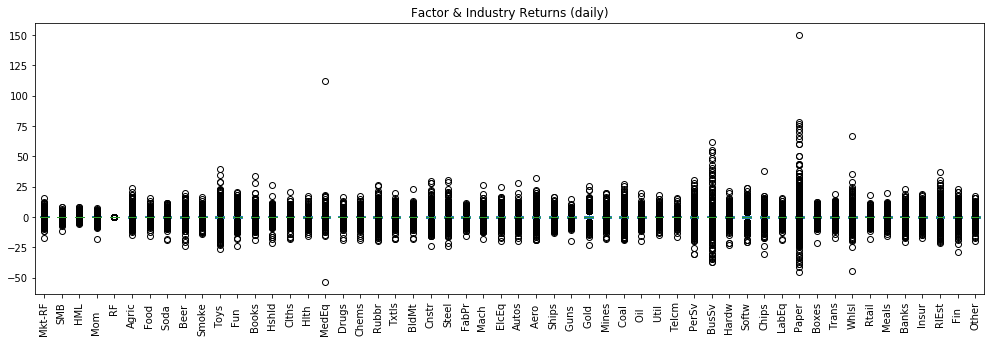

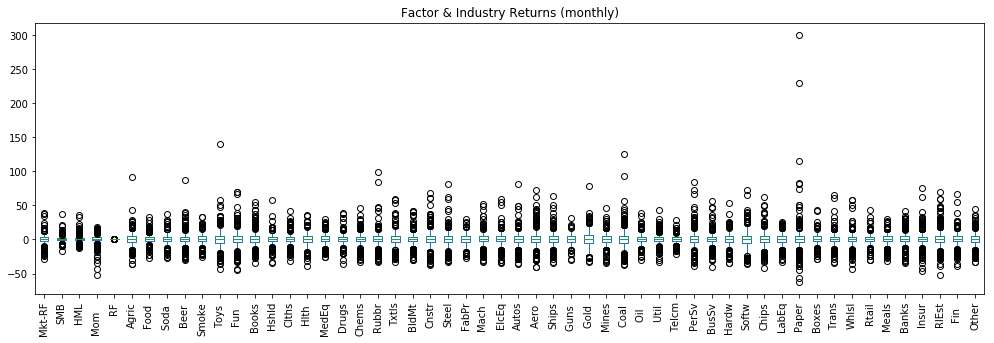

In [6]:
factors_daily.join(industries_daily).plot.box(title='Factor & Industry Returns (daily)', figsize=(17,5), rot=90)
factors_monthly.join(industries_monthly).plot.box(title='Factor & Industry Returns (monthly)', figsize=(17,5), rot=90)
plt.show()

## Markov switching models
For each asset $i$, asset returns $r^i_t$ are specified to follow a two state Markov regime switching process with state-dependent intercept $\alpha^i_{S_t}$ and state-dependent market beta $\beta^i_{S_t}$. More formally:

\begin{equation*}
   r^i_t = \alpha^i_{S_t} + r_t^M \beta^i_{S_t} + \varepsilon^i_{t},  \quad\quad   \varepsilon_{t} \sim N(0,\sigma^2_i)
\end{equation*}

where states $S_t \in \{0,1\}$ and the regimes switch according to the following transition matrix:

\begin{equation*}
    P(S^i_t = s^i_t \, | \, S^i_{t-1} = s^i_{t-1}) = 
    \begin{bmatrix}
        p^i_{00}& p^i_{10}\\
        1-p^i_{00} & 1-p^i_{10}\\
    \end{bmatrix}
\end{equation*}

The parameters $p^i_{00}, p^i_{10}, \alpha^i_0, \alpha^i_1, \beta^i_0, \beta^i_1, σ^2_i$ are estimated by maximum likelihood.

Note that different specifications with state-dependent variances $\sigma_{i,S_t}^2$ or more independent variables (factors) are possible to specify. However, the estimation becomes increasingly difficult with the number of additional parameters and the algorithm does not reliably converge in many cases. For this reason, I stick to the specification above for now.

*__NOTES:__* 
* _The value warning message frequently appears in this part, but can be ignored as it only refers to the indexing information._
* _In some cases the likelihood estimator does not converge and a convergence warning is displayed. The output values in these cases are NaN._
* _A problem with this approach is that it uses forward looking information._

#### Estimate on daily data

In [7]:
# set up output frame
regime_daily = pd.DataFrame(columns = industries_daily.columns, index = industries_daily.index)

# load independent variable
x = factors_daily.iloc[:, 0]

for iAsset in range(0,len(industries_daily.columns)):
    # extract industry data
    y = industries_daily.iloc[:, iAsset]
    
    # estimate model
    model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=x, switching_variance=False, switching_trend=True, missing='drop').fit()
    
    # save estimates
    regime_daily.iloc[:,iAsset] = model.smoothed_marginal_probabilities[0]
    
    # clear temporary variables
    del y, model
    
    # print progress
    if (iAsset+1)%1 is 0:
        print('finished',iAsset+1,'out of',len(industries_daily.columns))
    
del x

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 1 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 2 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 3 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 4 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 5 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 6 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 7 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 8 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 9 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 10 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 11 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1757: RuntimeWarning: divide by zero encountered in log
  self.llf_obs = np.log(self.joint_likelihoods)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaco

finished 12 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 13 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 14 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 15 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 16 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 17 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 18 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 19 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 20 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


finished 21 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 22 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 23 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 24 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 25 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 26 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 27 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 28 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 29 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 30 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 31 out of 49
finished 32 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 33 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


finished 34 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 35 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 36 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 37 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 38 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1757: RuntimeWarning: divide by zero encountered in log
  self.llf_obs = np.log(self.joint_likelihoods)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaco

finished 39 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 40 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 41 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


finished 42 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 43 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 44 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 45 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 46 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 47 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 48 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 49 out of 49


In [8]:
print((regime_daily.count()==0).sum(),'out of',len(industries_daily.columns),'models did not converge.')

4 out of 49 models did not converge.


#### Estimate on monthly data

In [9]:
# set up output frame
regime_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)

# load independent variable
x = factors_monthly.iloc[:, 0]

for iAsset in range(0,len(industries_monthly.columns)):
    # extract industry data
    y = industries_monthly.iloc[:, iAsset]
    
    # estimate model
    model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=x, switching_variance=False, switching_trend=True, missing='drop').fit()
    
    # save estimates
    regime_monthly.iloc[:,iAsset] = model.smoothed_marginal_probabilities[0]
    
    # clear temporary variables
    del y, model
    
    # print progress
    if (iAsset+1)%1 is 0:
        print('finished',iAsset+1,'out of',len(industries_monthly.columns))
    
del x

finished 1 out of 49
finished 2 out of 49
finished 3 out of 49
finished 4 out of 49
finished 5 out of 49
finished 6 out of 49
finished 7 out of 49
finished 8 out of 49
finished 9 out of 49
finished 10 out of 49
finished 11 out of 49
finished 12 out of 49
finished 13 out of 49
finished 14 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 15 out of 49
finished 16 out of 49
finished 17 out of 49
finished 18 out of 49
finished 19 out of 49
finished 20 out of 49
finished 21 out of 49
finished 22 out of 49
finished 23 out of 49
finished 24 out of 49
finished 25 out of 49
finished 26 out of 49
finished 27 out of 49
finished 28 out of 49
finished 29 out of 49
finished 30 out of 49
finished 31 out of 49
finished 32 out of 49
finished 33 out of 49
finished 34 out of 49
finished 35 out of 49
finished 36 out of 49
finished 37 out of 49
finished 38 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 39 out of 49
finished 40 out of 49
finished 41 out of 49
finished 42 out of 49
finished 43 out of 49
finished 44 out of 49
finished 45 out of 49
finished 46 out of 49
finished 47 out of 49
finished 48 out of 49
finished 49 out of 49


In [10]:
print((regime_monthly.count()==0).sum(),'out of',len(industries_daily.columns),'models did not converge.')

0 out of 49 models did not converge.


## Ambiguity proxy
If we assume that the agents' perceived ambiguity is related to the uncertainty of being in either of the two regimes, we can construct a measure of ambiguity based on the estimated marginal probabilities of being in either of the states. In this framework, maximum ambiguity is reached when the two states are equally likely (p=0.5). On the other hand there is no ambiguity if all the probability mass is on one state (either p=0 or p=1). Therefore, the measure is constructed as follows:

\begin{equation*}
    ambiguity^i_t = 1-4*\big(Pr [S^i_t = 0]-0.5\big)^2
\end{equation*}

This measure takes a value of one if both states are equally likely (maximum uncertainty), and zero if there is no uncertainty about what state the process is currently in.

Note that the current estimation technique is forward looking as the regime switching models are estimated using the full sample. This could be avoided by using rolling/expanding windows when estimating the models, which will be computationally challenging.

In [34]:
ambiguity_daily = 1-4*(regime_daily-0.5)**2
ambiguity_monthly = 1-4*(regime_monthly-0.5)**2

#### Daily estimates

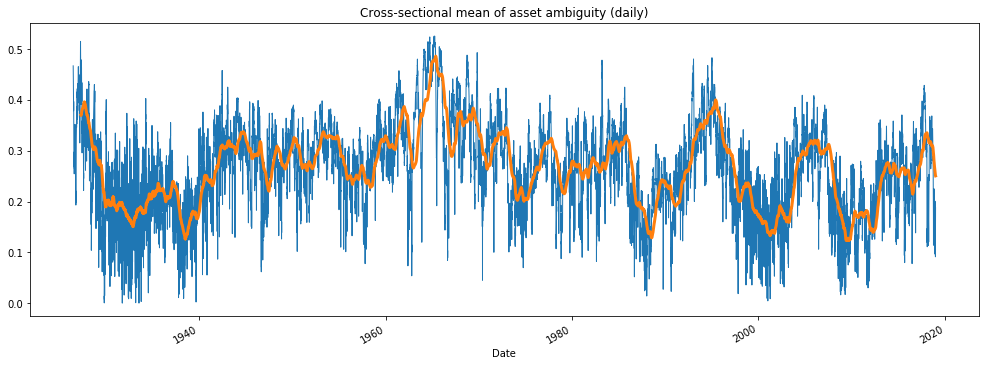

In [12]:
ambiguity_daily.iloc[:,:].mean(axis=1).plot(title='Cross-sectional mean of asset ambiguity (daily)', figsize=(17,6), legend=False, linewidth=1)
ambiguity_daily.iloc[:,:].mean(axis=1).rolling(250).mean().plot(figsize=(17,6), legend=False, linewidth=3)
#ambiguity_daily.iloc[:,:].mean(axis=1).rolling(1250).mean().plot(figsize=(17,6), legend=False)
plt.show()

#### Monthly estimates

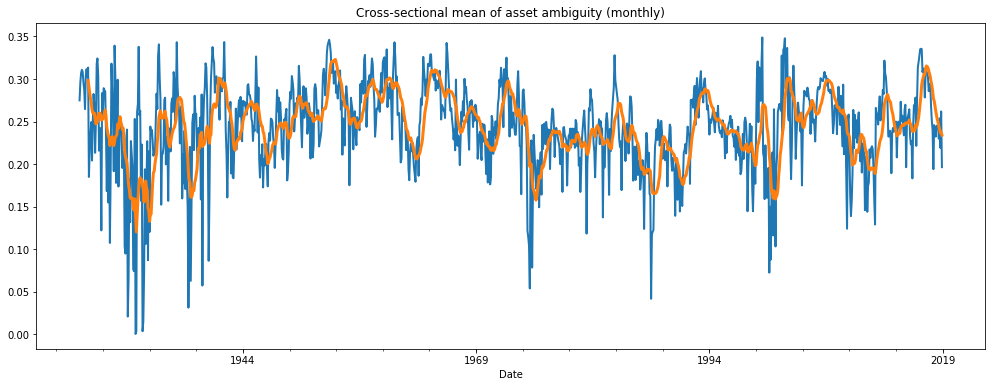

In [13]:
ambiguity_monthly.iloc[:,:].mean(axis=1).plot(title='Cross-sectional mean of asset ambiguity (monthly)', figsize=(17,6), legend=False, linewidth=2)
ambiguity_monthly.iloc[:,:].mean(axis=1).rolling(12).mean().plot(figsize=(17,6), legend=False, linewidth=3)
#ambiguity_monthly.iloc[:,:].mean(axis=1).rolling(60).mean().plot(figsize=(17,6), legend=False)
plt.show()

#### Distribution of measure

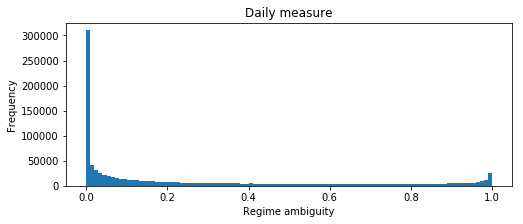

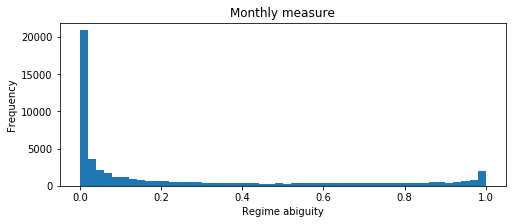

In [14]:
ambiguity_daily.stack().plot.hist(100, title='Daily measure', figsize=(8,3))
plt.xlabel('Regime ambiguity')
plt.show()
ambiguity_monthly.stack().plot.hist(50, title='Monthly measure', figsize=(8,3))
plt.xlabel('Regime abiguity')
plt.show()

#### Persistence of ambiguity measure

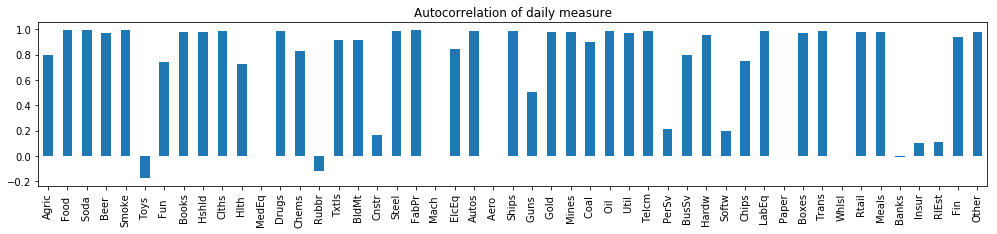

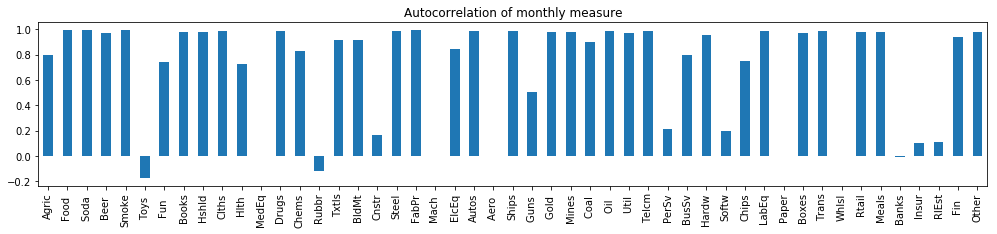

In [15]:
ambiguity_daily[ambiguity_daily>0.0001].apply(lambda col: col.autocorr(1), axis=0).plot.bar(figsize=(17,3), title='Autocorrelation of daily measure', color = 'C0')
plt.show()
ambiguity_daily[ambiguity_daily>0.0001].apply(lambda col: col.autocorr(1), axis=0).plot.bar(figsize=(17,3), title='Autocorrelation of monthly measure', color = 'C0')
plt.show()

## Pooled OLS regressions

#### Daily frequency

In [16]:
X = ambiguity_daily.rolling(1).mean().shift(1)
#.sub(ambiguity_daily.mean(axis=1), axis=0).div(ambiguity_daily.std(axis=1), axis=0)
X.columns = np.arange(49) #industries.columns
X = X.stack(dropna=False)
X = sm.add_constant(X)
X.columns = ['constant','ambiguity']

In [17]:
Y = industries_daily.rolling(1).mean()
#.sub(industries_daily.mean(axis=1), axis=0).div(industries_daily.std(axis=1), axis=0)
Y.columns = np.arange(49) #industries.columns
Y = Y.stack(dropna=False)

In [18]:
lm.PooledOLS(Y,X).fit(cov_type='kernel')

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Dep. Variable:,0,R-squared:,4.212e-05
Estimator:,PooledOLS,R-squared (Between):,0.0001
No. Observations:,997995,R-squared (Within):,-1.653e-05
Date:,"Tue, Jan 29 2019",R-squared (Overall):,4.212e-05
Time:,14:01:20,Log-likelihood,-1.845e+06
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,42.039
Entities:,24390,P-value,0.0000
Avg Obs:,40.918,Distribution:,"F(1,997993)"
Min Obs:,36.000,,
Max Obs:,45.000,F-statistic (robust):,23.117


#### Scatter plot

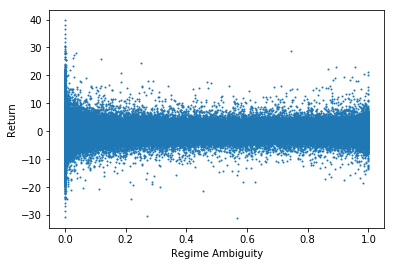

In [19]:
plt.scatter(X['ambiguity'],Y,1) 
plt.xlabel("Regime Ambiguity")
plt.ylabel("Return")
plt.show()

#### Monthly frequency

In [20]:
X = ambiguity_monthly.rolling(1).mean().shift(1)
#.sub(ambiguity_monthly.mean(axis=1), axis=0).div(ambiguity_monthly.std(axis=1), axis=0)
X.columns = np.arange(49) #industries.columns
X = X.stack(dropna=False)
X = sm.add_constant(X)
X.columns = ['constant','ambiguity']

In [21]:
Y = industries_monthly.rolling(1).mean()
#.sub(industries_monthly.mean(axis=1), axis=0).div(industries_monthly.std(axis=1), axis=0)
Y.columns = np.arange(49) #industries.columns
Y = Y.stack(dropna=False)

In [22]:
lm.PooledOLS(Y,X).fit(cov_type='kernel')

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Dep. Variable:,0,R-squared:,3.061e-05
Estimator:,PooledOLS,R-squared (Between):,-8.393e-05
No. Observations:,51335,R-squared (Within):,0.0002
Date:,"Tue, Jan 29 2019",R-squared (Overall):,3.061e-05
Time:,14:01:26,Log-likelihood,-1.772e+05
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,1.5713
Entities:,1109,P-value,0.2100
Avg Obs:,46.289,Distribution:,"F(1,51333)"
Min Obs:,39.000,,
Max Obs:,49.000,F-statistic (robust):,0.8735


#### Scatter plot

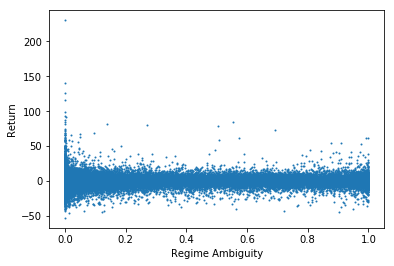

In [23]:
plt.scatter(X['ambiguity'],Y,1)
plt.xlabel("Regime Ambiguity")
plt.ylabel("Return")
plt.show()

## Sorted Portfolios

I exclude returns where the ambiguity measure is very close to zero (0.0001 or smaller). This excludes the following percentages of observations:

In [24]:
(ambiguity_daily<=0.0001).sum().sum()/(ambiguity_daily).count().sum()

0.21502022462003065

In [25]:
(ambiguity_monthly<=0.0001).sum().sum()/(ambiguity_monthly).count().sum()

0.15759156190402054

In [26]:
def sort_portfolios(returns, ranking_variable, n_portfolios, lags):
    sorting_variable = ranking_variable.shift(lags)
    include = ~returns.isna() & ~sorting_variable.isna()
    n_period = include.sum(axis=1)
    [t,n] = returns.shape
    cutoff_ranks = np.dot(n_period.values.reshape(t,1)/n_portfolios,np.arange(n_portfolios+1).reshape(1,n_portfolios+1)).round()
    asset_ranks = sorting_variable.rank(axis=1)
    portfolio_returns = pd.DataFrame(index=returns.index,columns=range(1,n_portfolios+1))
    portfolio_assets = pd.DataFrame(index=returns.index,columns=range(1,n_portfolios+1))
    for i_portfolio in range(0,n_portfolios):
        lower = cutoff_ranks[:,i_portfolio].reshape(t,1).repeat(n, axis=1)
        upper = cutoff_ranks[:,i_portfolio+1].reshape(t,1).repeat(n, axis=1)
        portfolio_returns[i_portfolio+1] = returns[(asset_ranks>lower) & (asset_ranks<=upper)].mean(axis=1)
        portfolio_assets[i_portfolio+1] = returns[(asset_ranks>lower) & (asset_ranks<=upper)].count(axis=1)
    return portfolio_returns

#### Daily portfolio sorts

In [27]:
portfolio_returns = sort_portfolios(industries_daily,ambiguity_daily[ambiguity_daily>0.0001],5,1)
portfolio_returns['5-1'] = portfolio_returns[5]-portfolio_returns[1] 

In [28]:
sorted_portfolios = pd.DataFrame(index = portfolio_returns.columns)
sorted_portfolios['mean'] = portfolio_returns.mean()
sorted_portfolios['std'] = portfolio_returns.std()
sorted_portfolios['N'] = portfolio_returns.count()
sorted_portfolios['t-stat'] = sorted_portfolios['mean']/(sorted_portfolios['std']/sorted_portfolios['N']**0.5)
sorted_portfolios['return p.a.'] = sorted_portfolios['mean']*250
sorted_portfolios['volatility p.a.'] = sorted_portfolios['std'] * (250**0.5)
sorted_portfolios['SR'] = sorted_portfolios['return p.a.']/sorted_portfolios['volatility p.a.']

1 is the low ambiguity portfolio and 5 is the high ambiguity portfolio.

In [29]:
sorted_portfolios

,mean,std,N,t-stat,return p.a.,volatility p.a.,SR
1,0.023978,1.055876,24389,3.546529,5.994587,16.694859,0.359068
2,0.027271,1.056685,24388,4.030406,6.817835,16.707665,0.408066
3,0.023423,1.105690,24386,3.308127,5.855785,17.482488,0.334951
4,0.032228,1.138358,24388,4.421161,8.056884,17.999022,0.447629
5,0.038596,1.215872,24389,4.957345,9.648951,19.224628,0.501906
5-1,0.014617,0.668094,24389,3.416891,3.654363,10.563495,0.345943


#### Monthly portfolio sorts

In [30]:
portfolio_returns = sort_portfolios(industries_monthly,ambiguity_monthly[ambiguity_monthly>0.0001],5,2)
portfolio_returns['5-1'] = portfolio_returns[5]-portfolio_returns[1]

In [31]:
sorted_portfolios = pd.DataFrame(index = portfolio_returns.columns)
sorted_portfolios['mean'] = portfolio_returns.mean()
sorted_portfolios['std'] = portfolio_returns.std()
sorted_portfolios['N'] = portfolio_returns.count()
sorted_portfolios['t-stat'] = sorted_portfolios['mean']/(sorted_portfolios['std']/sorted_portfolios['N']**0.5)
sorted_portfolios['return p.a.'] = sorted_portfolios['mean']*12
sorted_portfolios['volatility p.a.'] = sorted_portfolios['std'] * (12**0.5)
sorted_portfolios['SR'] = sorted_portfolios['return p.a.']/sorted_portfolios['volatility p.a.']

1 is the low ambiguity portfolio and 5 is the high ambiguity portfolio.

In [32]:
sorted_portfolios

,mean,std,N,t-stat,return p.a.,volatility p.a.,SR
1,0.658536,5.878601,1108,3.728856,7.902436,20.364072,0.388058
2,0.770136,6.057488,1107,4.230083,9.241637,20.983755,0.440419
3,0.813291,6.077174,1108,4.454657,9.759493,21.051947,0.463591
4,0.763995,6.054216,1107,4.198620,9.167943,20.972419,0.437143
5,0.789470,5.826230,1108,4.510428,9.473638,20.182654,0.469395
5-1,0.130933,2.412405,1108,1.806635,1.571202,8.356818,0.188014
